In [96]:
from reconstruct import * 
from projection_import import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import imageio
from scipy.ndimage import median_filter, uniform_filter
import re

In [97]:
# Specify the path to the HDF5 file
file_path = r"C:\Users\gdhakal\Documents\Git\Automatic_COR_finder\Si100_operando\6_230606_1426_Si100_operando_tomo___Z40_Y6315_20000eV_10x_400ms\6_230606_1426_00001.h5"

# Specify the folder to save and load the TIFF files
tiff_folder = r"C:\Users\gdhakal\Documents\Git\Automatic_COR_finder\Experiment Notebooks\Tiffs\Si100_6\overall"

# Create an instance of ProjectionFile
FileObject = ProjectionFile(file_path)

# Open the HDF5 file and retrieve the volume and metadata
volume_path = "/entry/data/data"
metadata_paths = ['/entry/instrument/NDAttributes/CT_MICOS_W']

volume, metadata = FileObject.openFile(volume=volume_path, metadata=metadata_paths)

volume opened successfully : data shape:  (2583, 2160, 2560)


### Reconstructing One Slice with Multiple Looped COR

In [98]:
#Assigning reco_setting values
reco_setting = {
    'angle_list_dir': '/entry/instrument/NDAttributes/CT_MICOS_W',
    'number_of_FFs': 20,
    'slice_number': 1000,
    'DarkFieldValue': 200,
    'backIlluminationValue': 0,
    'offset_Angle': 0,
    'angle_range': '180 - axis centered',
    'extend_FOV_fixed_ImageJ_Stream': 0.25,
    'reco_algorithm': 'gridrec',
    'filter_name': 'shepp',
    'pixel_size': 0.72,
    'ring_radius': 50
    }

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(52)

# Specify the range and number of random values
mean_value = 1216
min_value = 1000
max_value = 1500
num_values = 100

# Generate random COR values from a normal distribution
random_cor_values = np.random.normal(loc=mean_value, scale=100, size=num_values)
random_cor_values = np.clip(random_cor_values, min_value, max_value)  # Clip values to the specified range

        # Instantiate the Reconstruction object
recoObject = Reconstruction(FileObject, gpu=True)
        # Set the COR value in the reconstruction settings
reco_setting["COR"] = random_cor_values

        # Generate the Slice using the reco_settings
slice = recoObject.on_the_fly_one_slice(reco_setting)

        # Specify the intensity range
min_intensity = -100
max_intensity = 100

        # Clip the image intensities within the desired range
clipped_image = np.clip(slice, min_intensity, max_intensity)

        # Scale the intensities to the range [0, 255]
scaled_image = ((clipped_image - min_intensity) / (max_intensity - min_intensity) * 255).astype(np.uint8)

str_cor_value = str(random_cor_values).replace ('.' , 'p' )

        # Save the reconstructed slice
save_file_name = f"reconstructed_cor{str_cor_value}.tif"
        # np.save(save_file_name, slice)

        # Save the scaled image as a TIFF file
imageio.imwrite(os.path.join(tiff_folder, save_file_name), scaled_image)

print("Reconstructed slice saved successfully as", save_file_name)    

In [ ]:
# Function to read and give COR, e, and n of a file
def parse_reconstructed_filename(filename):
    # Extract COR, e, and n values from the filename using regular expressions
   # match = re.search(r"reconstructed_e(\d+)_n(\d+)_cor(\d+p\d+)\.tif", filename)
    match = re.search(r"reconstructed_cor(\d+p\d+)\.tif|reconstructed_cor(\d+)\.tif", filename)
    
    if match:
        if match.group(3):
            e1 = int(match.group(1))
            n1 = int(match.group(2))
            cor = float(match.group(3).replace("p", "."))
        else:
            e1 = int(match.group(4))
            n1 = int(match.group(5))
            cor = float(match.group(6))

        return cor, e1, n1
    
    return None

# Initialize arrays to store COR, e, and n values
cor_file = []
e_file = []
n_file = []
path = []
fname = []

# Iterate over the TIFF files in the directory
for filename in os.listdir(tiff_folder):
    if filename.endswith(".tif"):
        # Get the full file path
        filepath = os.path.join(tiff_folder, filename)
        
        # Parse the COR, e, and n values from the filename
        result = parse_reconstructed_filename(filename)
        
        if result:
            cor, e1, n1 = result
            # Append the values to the respective arrays
            cor_file.append(cor)
            e_file.append(e1)
            n_file.append(n1)
            path.append(filepath)
            fname.append(filename)

# Print the arrays
df_description = pd.DataFrame({"path": path, "filename": fname, "COR": cor_file})


In [ ]:
# Create a histogram to visualize the distribution of random COR values
plt.figure(figsize=(10, 6))
plt.hist(random_cor_values, bins=20, edgecolor='black', alpha=0.5)
plt.xlabel('COR Values')
plt.ylabel('Frequency')
plt.title('Histogram of Random COR Values')
plt.grid(True)
plt.show()

In [ ]:
# Function to calculate standard deviation
def calculate_std(path):
    image = Image.open(path)  # Read the image based on the filename
    image_array = np.array(image)
    std = np.std(image_array)
    return std

# Apply the function to calculate standard deviation for each file
df_description['std_dev'] = df_description['path'].apply(calculate_std)

In [ ]:
plt.scatter(df_description["COR"],df_description["std_dev"])
plt.xlabel('COR Values')
plt.ylabel('Standard Deviation')
plt.title('COR vs. Standard Deviation')
plt.grid(True)
plt.show()

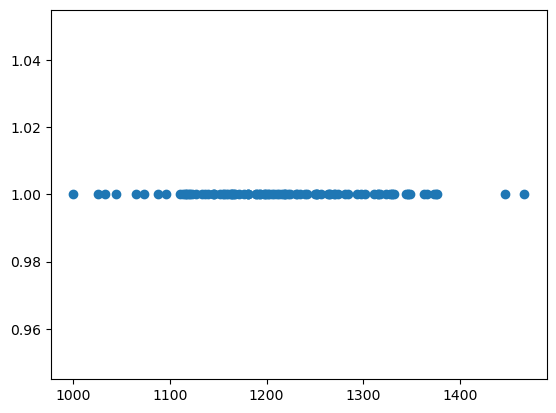

In [17]:
plt.plot(  random_cor_values , [1 for i in range(len(random_cor_values))]
         , 'o')

In [115]:
# Function to read and give COR, e, and n of a file
def parse_reconstructed_filename(filename):
    # Extract COR, e, and n values from the filename using regular expressions
   # match = re.search(r"reconstructed_e(\d+)_n(\d+)_cor(\d+p\d+)\.tif", filename)
    match = re.search(r"reconstructed_e(\d+)_n(\d+)_cor(\d+p\d+)\.tif|reconstructed_e(\d+)_n(\d+)_cor(\d+)\.tif", filename)
    
    if match:
        if match.group(3):
            e1 = int(match.group(1))
            n1 = int(match.group(2))
            cor = float(match.group(3).replace("p", "."))
        else:
            e1 = int(match.group(4))
            n1 = int(match.group(5))
            cor = float(match.group(6))

        return cor, e1, n1
    
    return None

# Initialize arrays to store COR, e, and n values
cor_file = []
e_file = []
n_file = []
path = []
fname = []

# Iterate over the TIFF files in the directory
for filename in os.listdir(tiff_folder):
    if filename.endswith(".tif"):
        # Get the full file path
        filepath = os.path.join(tiff_folder, filename)
        
        # Parse the COR, e, and n values from the filename
        result = parse_reconstructed_filename(filename)
        
        if result:
            cor, e1, n1 = result
            # Append the values to the respective arrays
            cor_file.append(cor)
            e_file.append(e1)
            n_file.append(n1)
            path.append(filepath)
            fname.append(filename)

# Print the arrays
df_description = pd.DataFrame({"path": path, "filename": fname, "COR": cor_file, "e": e_file, "n": n_file})


In [111]:
df_description["COR"]

0     1112.5
1     1122.5
2     1132.5
3     1142.5
4     1152.5
5     1162.5
6     1172.5
7     1182.5
8     1192.5
9     1202.5
10    1212.5
11    1222.5
12    1232.5
13    1242.5
14    1252.5
15    1262.5
16    1272.5
17    1282.5
18    1292.5
19    1302.5
20    1312.5
21    1202.5
22    1203.5
23    1204.5
24    1205.5
25    1206.5
26    1207.5
27    1208.5
28    1209.5
29    1210.5
30    1211.5
31    1212.5
32    1213.5
33    1214.5
34    1215.5
35    1216.5
36    1217.5
37    1218.5
38    1219.5
39    1220.5
40    1221.5
41    1222.5
Name: COR, dtype: float64

### Experiment One - Finding Standard Deviation and Plotting It
#### Overall Standard Deviation

In [116]:
# Function to calculate standard deviation
def calculate_std(path):
    image = Image.open(path)  # Read the image based on the filename
    image_array = np.array(image)
    std = np.std(image_array)
    return std

# Apply the function to calculate standard deviation for each file
df_description['std_dev'] = df_description['path'].apply(calculate_std)

# Print the updated DataFrame
#print(df_description)

In [ ]:
plt.scatter(df_description["COR"],df_description["std_dev"])
plt.xlabel('COR Values')
plt.ylabel('Standard Deviation')
plt.title('COR vs. Standard Deviation')
plt.grid(True)
plt.show()

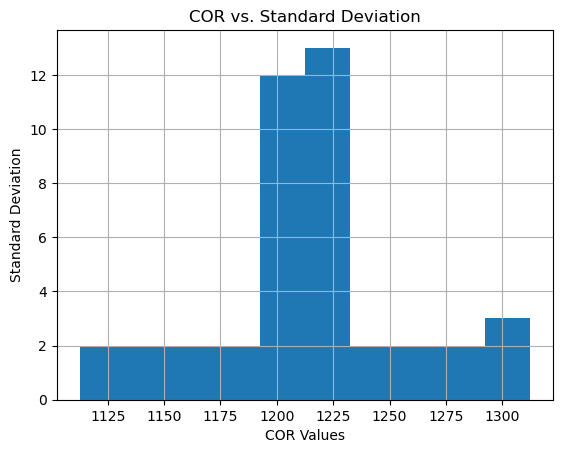

In [118]:
plt.hist(df_description["COR"])
plt.xlabel('COR Values')
plt.ylabel('Standard Deviation')
plt.title('COR vs. Standard Deviation')
plt.grid(True)
plt.show()

In [ ]:
# Find the file with the maximum standard deviation
max_std_dev_row = df_description.loc[df_description["std_dev"].idxmax()]

# Access the filename and maximum standard deviation value
largest_file = max_std_dev_row["filename"]
largest_std_dev = max_std_dev_row["std_dev"]

print("File with Maximum Standard Deviation:", largest_file, "With Deviation:", largest_std_dev)

In [ ]:
# df_description.drop(columns='midpoint')

##### Mean Filter

In [ ]:
# # Function to calculate mean filtered standard deviation
# def calculate_mean_std(path):
#     image = Image.open(path)  # Read the image based on the filename

#     # Apply mean filter
#     mean_filtered = uniform_filter(image, size=3) 

#     mean_image_array = np.array(mean_filtered)
#     mean_std = np.std(mean_image_array)
#     return mean_std

# # Apply the function to calculate standard deviation for each file
# df_description['mean_std_dev'] = df_description['path'].apply(calculate_mean_std)

# # Print the updated DataFrame
# #print(df_description)

In [ ]:
# plt.scatter(df_description["COR"],df_description["mean_std_dev"])
# plt.xlabel('COR Values')
# plt.ylabel('Standard Deviation')
# plt.title('COR vs. Mean Filtered Standard Deviation')
# plt.grid(True)
# plt.show()

##### Median Filter

In [ ]:
# # Function to calculate standard deviation
# def calculate_median_std(path):
#     image = Image.open(path)  # Read the image based on the filename

#     # Apply median filter
#     median_filtered = median_filter(image, size=3)

#     image_array = np.array(median_filtered)
#     median_std = np.std(image_array)
#     return median_std

# # Apply the function to calculate standard deviation for each file
# df_description['median_std_dev'] = df_description['path'].apply(calculate_median_std)

# # Print the updated DataFrame
# #print(df_description)

In [ ]:
# plt.scatter(df_description["COR"],df_description["median_std_dev"])
# plt.xlabel('COR Values')
# plt.ylabel('Standard Deviation')
# plt.title('COR vs. Median Filtered Standard Deviation')
# plt.grid(True)
# plt.show()

#### Cropped Standard Deviation

In [ ]:
# # Function to calculate cropped standard deviation
# def calculate_cropped_std(path):
#     image = Image.open(path)  # Read the image based on the filename
#     width, height = image.size
#     left = (width - 200) // 2
#     top = (height - 200) // 2
#     right = left + 200
#     bottom = top + 200
#     cropped_image = image.crop((left, top, right, bottom))

#     image_array = np.array(cropped_image)
#     cropped_std = np.std(image_array)
#     return cropped_std

# # Apply the function to calculate standard deviation for each file
# df_description['cropped_std_dev'] = df_description['path'].apply(calculate_cropped_std)

# # Print the updated DataFrame
# #print(df_description)

In [ ]:
# plt.scatter(df_description["COR"],df_description["cropped_std_dev"])
# plt.xlabel('COR Values')
# plt.ylabel('Standard Deviation')
# plt.title('COR vs. Cropped Standard Deviation')
# plt.grid(True)
# plt.show()

##### Varience Filter

In [ ]:
# # Function to calculate the variance of an image
# def calculate_variance(image_path):
#     image = Image.open(image_path)
#     imarray = np.array(image)
#     return np.var(imarray)

# # Set the path to the folder containing the reconstructed TIFFs
# reconstructed_folder = "path/to/reconstructed_tiffs_folder"

# # Set the variance threshold
# variance_threshold = 1000  # You can adjust this value as needed

# # List to store the selected TIFF files
# selected_tiffs = []

# # Iterate over the TIFF files in the directory
# for filename in os.listdir(reconstructed_folder):
#     if filename.endswith(".tif"):
#         # Get the full file path
#         filepath = os.path.join(reconstructed_folder, filename)
        
#         # Calculate the variance of the image
#         variance = calculate_variance(filepath)
        
#         # Check if the variance is above the threshold
#         if variance > variance_threshold:
#             selected_tiffs.append(filepath)